In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00


In [4]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=87263fbcfb9399e625695a5cdee261355050d06d9e5098df602021b52024cdae
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [8]:
import kagglehub

import re
from time import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score



import torch

# EDA

In [9]:
# Запуск таймера
start_time = time()

df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


### Удаление дубликатов и заполнение пропусков

In [10]:
# Видим выще, что пропусков нет
# Посмотрим датафрейм
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [12]:
# Удаление дубликатов
df.drop_duplicates(ignore_index = True)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28612,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28613,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28614,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28615,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [13]:
# Удалим столбец со ссылкой, т.к. он не требуется для классификации текста
df = df.drop(columns='article_link')

In [14]:
list(df.head(10)['headline'])

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly",
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario']

Как видно из выборки заголовков, используется литературный стиль написания заголовков, отсутствуют слова-паразиты, сокращения, ссылки, смайлики и прочее, что стоило бы удалить из текста.

### Проверка дисбаланса классов

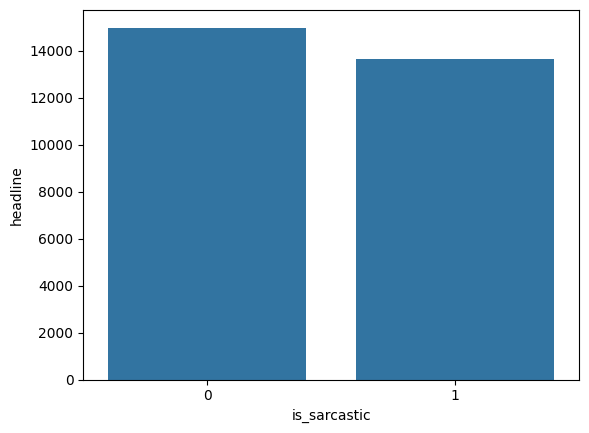

In [15]:
sns.barplot(df.groupby('is_sarcastic').agg('count')['headline']);

Как видно из графика, классы довольно сбалансированы

### Удаление выбросов

In [16]:
# Длины заголовков
df.headline.str.len().describe()

,headline
count,28619.000000
mean,62.308571
std,20.726483
min,7.000000
25%,49.000000
50%,62.000000
75%,75.000000
max,926.000000


In [17]:
# Вычисление длины строк
df['length'] = df['headline'].str.len()

# Вычисление квартилей и IQR
Q1 = df['length'].quantile(0.25)
Q3 = df['length'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов
df_cleaned = df[(df['length'] >= lower_bound) & (df['length'] <= upper_bound)]

# Удаление столбца с длиной строки
df_cleaned = df_cleaned.drop(columns='length')

# Проверка результата
print("Исходный размер DataFrame:", df.shape)
print("Размер DataFrame после удаления выбросов:", df_cleaned.shape)

Исходный размер DataFrame: (28619, 3)
Размер DataFrame после удаления выбросов: (28315, 2)


In [18]:
# Длины заголовков
df_cleaned.headline.str.len().describe()

,headline
count,28315.000000
mean,61.628042
std,18.981161
min,10.000000
25%,49.000000
50%,62.000000
75%,74.000000
max,114.000000


# Data Preparing

In [19]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
# Инициализация лемматизатора и получение списка стоп-слов
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Функция для токенизации, удаления стоп-слов и лемматизации
def preprocess_text(text):
    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Оставляем только буквы и пробелы
    # Токенизация
    tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру
    # Удаление стоп-слов и лемматизация
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned_tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Применяем функцию к столбцу headline
df_prepared = df_cleaned.copy()
df_prepared['headline'] = df_cleaned['headline'].apply(preprocess_text)

df_prepared

,is_sarcastic,headline
0,1,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep totally nail congress falling short ge...
2,0,eat veggie deliciously different recipe
3,1,inclement weather prevents liar getting work
4,1,mother come pretty close using word streaming ...
...,...,...
28614,1,jew celebrate rosh hashasha something
28615,1,internal affair investigator disappointed cons...
28616,0,beautiful acceptance speech week came queer ko...
28617,1,mar probe destroyed orbiting spielberggates sp...


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared['headline'], df_prepared['is_sarcastic'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19820,), (8495,), (19820,), (8495,))

### Модели


In [26]:
# Векторизация текстовых данных
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [27]:
# Список моделей для обучения
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

In [28]:
# Словари для хранения результатов
results = {}
predictions = {}
# Завершение таймера
end_time = time()
prep_time = end_time - start_time

In [50]:
# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    start_time = time()  # Запуск таймера
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    end_time = time()  # Остановка таймера

    # Сохранение результатов
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'time': end_time - start_time + prep_time  # Добавление времени подготовки
    }

# Преобразование результатов в DataFrame для удобства
results_df = pd.DataFrame(results).T

In [30]:
# Вывод результатов
print(results_df)

                     accuracy  f1_score  precision    recall        time
Logistic Regression  0.794585  0.775620   0.812500  0.741943   60.806596
Naive Bayes          0.795174  0.781462   0.798306  0.765314   60.149721
Random Forest        0.752325  0.697875   0.838220  0.597786  133.214760
SVM                  0.782107  0.751243   0.827903  0.687577  161.789590


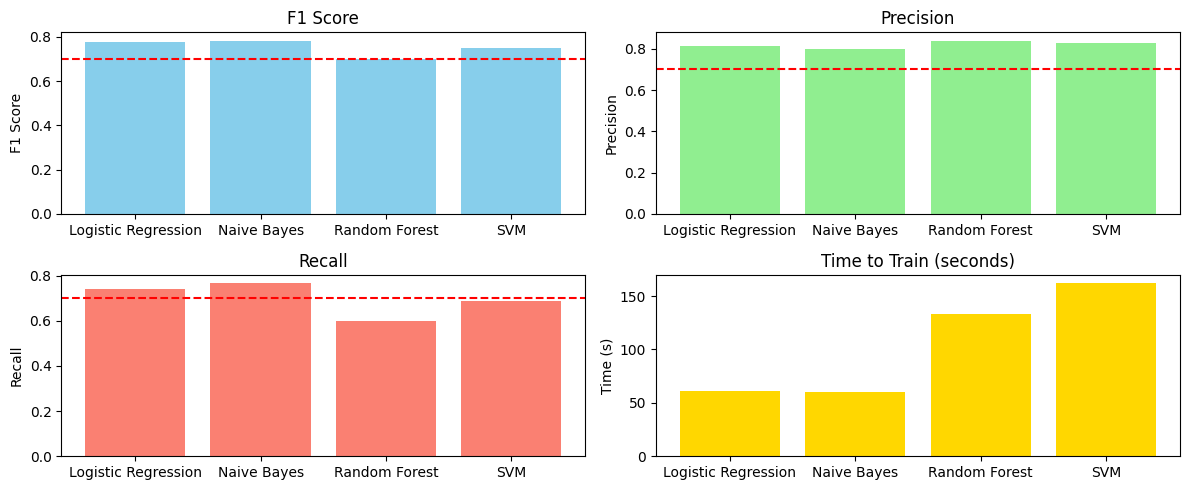

In [31]:
# Построение графиков
fig, axs = plt.subplots(2, 2, figsize=(12, 5))

# График F1 Score
axs[0, 0].bar(results_df.index, results_df['f1_score'], color='skyblue')
axs[0, 0].set_title('F1 Score')
axs[0, 0].set_ylabel('F1 Score')
axs[0, 0].axhline(y=0.7, color='r', linestyle='--')  # Линия для 70%

# График Precision
axs[0, 1].bar(results_df.index, results_df['precision'], color='lightgreen')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].axhline(y=0.7, color='r', linestyle='--')

# График Recall
axs[1, 0].bar(results_df.index, results_df['recall'], color='salmon')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].axhline(y=0.7, color='r', linestyle='--')

# График времени выполнения
axs[1, 1].bar(results_df.index, results_df['time'], color='gold')
axs[1, 1].set_title('Time to Train (seconds)')
axs[1, 1].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()

Как видим, все модели показывают хорошие результаты, однако модель Random Forest проигрывает в метрике Recall.

Также здесь показано, сколько времени потрачено на прогнозирование. В данном случае видно, что необходимости использовать более сложную модель (например, SVM) для конкретной задачи нет, так как в метриках выигрыша нет, зато есть проигрыш по времени работы модели.

По полученным метрикам выигрывает модел Naive Bayes

Попробуем расчитать KPI моделей для автоматического выбора лучшей.

In [51]:
def best_model(results_df):

    # Нормализация времени
    results_df['normalized_time'] = (results_df['time'] - results_df['time'].min()) / (results_df['time'].max() - results_df['time'].min())

    # Расчет KPI
    results_df['KPI'] = (results_df['accuracy'] +
                     results_df['f1_score'] +
                     results_df['precision'] +
                     results_df['recall'] -
                     results_df['normalized_time'])
    print(results_df)

    # Поиск модели с максимальным KPI
    best_model_index = results_df['KPI'].idxmax()
    best_model = results_df.loc[best_model_index]
    print("")
    print("*"*100)
    print("Лучшая модель:")
    print(best_model.name)  # Выводим всю информацию о лучшей модели

    return best_model

model=best_model(results_df)

                     accuracy  f1_score  precision    recall        time  \
Logistic Regression  0.794585  0.775620   0.812500  0.741943   60.542398   
Naive Bayes          0.795174  0.781462   0.798306  0.765314   60.164862   
Random Forest        0.755150  0.704545   0.833613  0.610086  115.715132   
SVM                  0.782107  0.751243   0.827903  0.687577  165.658197   

                     normalized_time       KPI  
Logistic Regression         0.003579  3.121070  
Naive Bayes                 0.000000  3.140256  
Random Forest               0.526576  2.376819  
SVM                         1.000000  2.048830  

****************************************************************************************************
Лучшая модель:
Naive Bayes
